# Blue or Red

The objective of this project is to create a **Blue-or-Red** (Democrat or Republican) classifier of tweets. This will be trained recent tweets from all members of Congress with a twitter handle. A latter phase of the project would be to see if the classifier could be extended to provide a **Blue-or-Red** classification to tweets in general (as opposed to just members of Congress).

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text.all import *
from rich import inspect

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Congressional Legislators

The list of twitter handles was obtained here: https://github.com/unitedstates/congress-legislators/. In particular, I used the csv format: https://theunitedstates.io/congress-legislators/legislators-current.csv I created a smaller csv file `legislators-with-twitter.csv `, which included the attributes of `twitter`, `party` for each member of congress.

The most time intensive part of the data preparation was downloading the tweets. Here is the code that I used, though I ran it as a script. It reads the `legislators-with-twitter.csv` file and downloads the last 100 pages of tweets for each member of congress. (A page is a Twitter construct containing roughly 20-25 tweets.) The tweets for each member of congress were saved to separate csv files. Each file contains these attributes: `handle`, `time`, `party` and `text`. Each of these file were save in the `data` directory.

Get the **Name**, **state**, **Party** affiliation and the **twitter** handle for each member of Congress. Need to make sure that everyone has a **twitter** handle. One does not.

In [3]:
def get_legislators():
    url = "https://theunitedstates.io/congress-legislators/legislators-current.csv"
    df = pd.read_csv(url)
    df = df[['first_name','last_name', 'state', 'party', 'twitter']]
    df = df[(df.party == 'Democrat') | (df.party == 'Republican')]
    df = df.rename(columns={'twitter':'handle'})
    df = df[df.handle.notnull()]
    return(df)

In [4]:
dfl = get_legislators()
dfl.head()

,first_name,last_name,state,party,handle
0,Sherrod,Brown,OH,Democrat,SenSherrodBrown
1,Maria,Cantwell,WA,Democrat,SenatorCantwell
2,Benjamin,Cardin,MD,Democrat,SenatorCardin
3,Thomas,Carper,DE,Democrat,SenatorCarper
4,Robert,Casey,PA,Democrat,SenBobCasey


### Twitter API

There were several python modules for Twitter, I choose tweepy: http://www.tweepy.org. It seemed fairly broadly used and is actively developed.

In order to gather the tweets, I needed to set up a developer account with Twitter in order to use their api. This was free. (Setting this up is described here https://developer.twitter.com and in other on-line resources.) I then created an App for this project and obtained the following keys/tokens: `API Key`, `API Seceret Key` and `Bearer Token`. Only the `Bearer Token` was required for this project.

**Without an Academic Account, Twitter limits searches to the past 7 days. Accordingly, all of the tweets used in this model are based on only 7 days of tweets**

### Download and Save Tweets

Using the function: `get_tweets_of(handle)`, download and save a file `<handle>.csv` for each member of Congress. These are saved in the directory `tweets-{date}`.

In [5]:
import tweepy, csv
import config  # Authentication Tokens

client = tweepy.Client(config.BEARER_TOKEN)

def get_tweets_of(handle, path='.', limit=1000):
    path = Path(path)/handle
    query = f'from:{handle} -is:retweet'
    res = []
    with open(path.with_suffix('.csv'), "w") as fn:
        writer = csv.writer(fn, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['handle','text'])
        for tweet in tweepy.Paginator(client.search_recent_tweets, query = query).flatten(limit=limit):
            text = clean_text(tweet.text)
            writer.writerow([handle, text])
    print(f'{handle}.csv')


def clean_text(text):
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub('[\\r,\\n]','', text)
    return text

There is a rate cap for the **twittter-api** which eventually throws an error:
```python
Too ManyRequests: 429 Too Many Requests`
```
After the error, the **twitter-api** waits for 15 minutes to resume.

The function: `download_tweets()` uses `get_legislators()` to get a list of the handles of each member of Congress and then repeatedly downloads and saves these tweets to `<handle>.csv` file. It catches the rate cap error, waits for 15 minutes and then resumes downloading. 

Without access to an academic account, I set this to run every 7 days to get more tweets for training. Here, I have two weeks of tweets.

In [6]:
import time
from datetime import date
from get_tweets_of import *
from get_legislators import *

def download_tweets():
    df = get_legislators()
    handles = df.handle
    path = f"tweets-{str(date.today())}"
    Path(path).mkdir(parents=True, exist_ok=True)
    for handle in handles:
        try:
            get_tweets_of(handle, path)
        except:
            for m in range(15):
                print(f"Minutes waiting: {m}")
                time.sleep(65)
            get_tweets_of(handle, path)

In [7]:
print("Getting Legislator Tweets")
print(f"Saving to: tweets-{str(date.today())}")
#download_tweets()

Getting Legislator Tweets
Saving to: tweets-2022-05-25


###  Read all Tweets into a Single Dataframe

Read the tweets `<handle.csv>` of each member of Congress into a new dataframe.

In [8]:
path = Path()
weeks = [path/'tweets-congress-2022-05-18', path/'tweets-congress-2022-05-24']

In [9]:
df = pd.DataFrame(columns=['handle','text']) 
for week in weeks:       
    for t in week.ls():
        dft = pd.read_csv(t)
        df  = pd.concat([df,dft],ignore_index=True)

In [10]:
len(df)

17289

Merge the tweet dataframe with the legislative dataframe to label each tweet as **Democrat** or **Republican** and then cleanup `text` 

In [11]:
def cleanup_text(df):
    df.text = df.text.str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '')
    df = df[(df.party == 'Democrat') | (df.party == 'Republican')]
    df = df[df.text.notnull()]
    df.text = df.text.str.replace('[\\r,\\n]','')
    df = df.dropna()
    df = df.reset_index()
    return df

In [12]:
df = df.merge(dfl)
df = cleanup_text(df)

Randomize

In [13]:
df = df.iloc[np.random.permutation(len(df))]; df
df.head()

,index,handle,text,first_name,last_name,state,party
7115,7128,RosaDeLauro,I encourage everyone to watch @AppropsDems’ hearing with the @US_FDA. There must be accountability for the contaminated formula found at an Abbott facility in Sturgis MI and FDA’s delay in investigating whistleblower claims alleging wrongdoing.We need answers.,Rosa,DeLauro,CT,Democrat
2702,2706,RepDebDingell,Joined the @GREconClub with my friend @RepFredUpton to discuss the current political climate &amp; how we can come together to get important work done. There are many issues that matter to us all &amp; if we approach them in the right way we can cut through the gridlock.,Debbie,Dingell,MI,Democrat
13464,13489,SenWhitehouse,"Justice Kagan has it right in her dissent: greenlighting the payment schemes at issue in this case ""bring[s] this country’s political system into further disrepute.""",Sheldon,Whitehouse,RI,Democrat
2253,2257,SenatorDurbin,It is noteworthy that Police Week falls during Mental Health Awareness Month. The Judiciary Committee will use this opportunity not just to pause and honor our law enforcement officers and their families but also to take action to improve mental health resources for them.,Richard,Durbin,IL,Democrat
11806,11826,MazieHirono,My bill to name the ALOHA VA Clinic after the late Senator Daniel Kahikina Akaka is on its way to @POTUS's desk to be signed into law. The facility spearheaded by Sen. Akaka will serve thousands &amp; honor his legacy of service to Hawaii &amp; our veterans.,Mazie,Hirono,HI,Democrat


In [ ]:
df[['text','party']].to_csv('blue_red_training_valid.csv', index=False)

Double check that csv file wasn't corrupted

In [ ]:
#df2 = pd.read_csv("blue_red_training_valid.csv")
#len(df), len(df2), len(df.text), len(df2.text),sum(df.text == df2.text),# sum(df.party == df2.party),sum((df.party == 'Democrat') == (df2.party == 'Democrat'))

In [16]:
sum(df.party=='Democrat')/len(df.party)

0.5810140614971702

### Prepare Dataloader

In [17]:
dls = TextDataLoaders.from_csv(path, csv_fname="blue_red_training_valid.csv",text_col='text', label_col="party")

In [18]:
dls.show_batch()

,text,category
0,xxbos xxmaj xxunk xxmaj xxunk xxmaj baltimore xxmaj city xxup p.d . 12 / 23 / xxunk xxmaj andrew xxmaj xxunk xxmaj xxunk xxup p.d . 4 / 28 / xxunk xxmaj michael xxmaj xxunk xxmaj frederick xxmaj city xxup p.d . 12 / 28 / xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxup p.d . 1 / 14 / xxunk xxmaj guy xxmaj collins xxmaj maryland xxmaj state xxmaj division xxmaj of xxmaj correction 6 / 4 / xxunk in xxmaj power .,Democrat
1,xxbos xxmaj if you or someone you know is in crisis please reach out . xxmaj you are not xxunk xxmaj suicide xxmaj prevention xxmaj lifeline : 1 - 800 - 273 - 8255 xxmaj en xxmaj español : 1- xxrep 3 8 xxunk - xxunk xxmaj deaf & & xxmaj hard of xxmaj hearing : 1 - 800 - 273 - 8255 ( tty users : use your xxunk xxunk service or dial xxunk then 1 - 800 - 273 - 8255 ),Democrat
2,xxbos xxmaj if you or someone you know is in crisis please reach out . xxmaj you are not xxunk xxmaj suicide xxmaj prevention xxmaj lifeline : 1 - 800 - 273 - 8255 xxmaj en xxmaj español : 1- xxrep 3 8 xxunk - xxunk xxmaj deaf & & xxmaj hard of xxmaj hearing : 1 - 800 - 273 - 8255 ( tty users : use your xxunk xxunk service or dial xxunk then 1 - 800 - 273 - 8255 ),Democrat
3,xxbos 📍 xxmaj xxunk xxmaj xxunk xxmaj tribe : $ xxunk 📍 xxmaj xxunk xxmaj band of xxmaj xxunk : $ xxunk 📍 paiute - xxunk xxmaj tribe : $ xxunk 📍 xxmaj xxunk xxmaj lake xxmaj paiute xxmaj tribe : $ xxunk 📍 xxmaj reno xxmaj sparks xxmaj indian xxmaj xxunk : $ xxunk 📍 xxmaj walker xxmaj river xxmaj paiute xxmaj tribe : $ xxunk 📍 xxmaj xxunk xxmaj tribe of xxmaj nevada and xxmaj california : $ xxunk,Democrat
4,xxbos xxmaj future defenders : xxmaj great talking leadership and military with @westpoint_usma xxmaj cadets xxmaj garrett xxmaj xxunk ( xxunk xxup xxunk ) xxmaj thomas xxmaj ward ( jasper xxup al ) xxmaj xxunk xxmaj van de xxmaj wall ( xxunk xxmaj city xxup md ) xxmaj jack xxmaj may ( burlington xxup nc ) xxmaj michael xxmaj xxunk ( xxunk xxup il ) and xxmaj xxunk xxmaj xxunk ( xxunk xxup oh ) . xxmaj go xxmaj army !,Republican
5,xxbos xxmaj the average gas price in xxmaj south xxmaj carolina today is $ xxunk . xxmaj that 's up from $ 4.22 just a week ago $ xxunk a month ago & & $ xxunk a year ago ( xxrep 3 a ) . xxmaj south xxmaj carolinians ca n't afford xxmaj joe xxmaj biden 's self - imposed # energycrisis all because he refuses to end his war on xxmaj american energy xxunk ⛽ ️,Republican
6,xxbos # xxmaj trump 's enactment of # xxmaj title42 saved thousands of lives by slowing the spread of # xxup covid & & by curbing the flow of # fentanyl into the # xxup us . xxmaj i 'm proud to co - sponsor # xxup xxunk which allows # xxmaj title42 to be used for fentanyl / other drugs which are the leading cause of death for 18 - 45 y / o.,Republican
7,xxbos xxmaj this week in fl 's xxmaj fort xxunk - xxunk xxmaj xxunk region gas prices hit an all - time record of $ 4.48 . xxmaj one year ago gas prices were at $ xxunk month in fl 's xxmaj fort xxunk - xxunk xxmaj xxunk region diesel prices hit an all - time record of $ xxunk . xxmaj one year ago diesel prices were at $ xxunk .,Republican
8,xxbos xxmaj on this week ’s # xxunk join # xxmaj bellingham xxmaj american xxmaj legion xxmaj post 7 xxmaj commander xxmaj al xxmaj xxunk & & me to discuss ⬇ ️ ✔ xxmaj action to address the infant formula shortage ✔ xxmaj the xxmaj honoring xxmaj our xxup pact xxmaj act ✔ xxmaj efforts to ensure 59 xxrep 3 0 + # xxup wa02 veterans can access the resources they need,Democrat


In [19]:
learner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(valley=0.0030199517495930195)

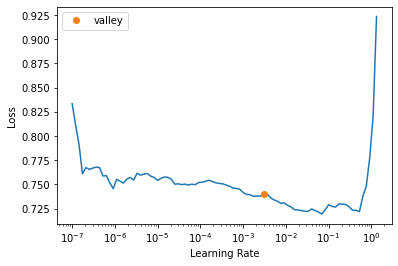

In [20]:
learner.lr_find()

In [21]:
learner.fine_tune(8, .005)

epoch,train_loss,valid_loss,accuracy,time
0,0.607742,0.557907,0.706741,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.552444,0.493648,0.760140,00:12
1,0.512261,0.446947,0.789028,00:12
2,0.452405,0.411675,0.810913,00:12
3,0.392998,0.401718,0.811205,00:12
4,0.332708,0.375972,0.835425,00:12
5,0.262604,0.395524,0.838051,00:12
6,0.230470,0.408174,0.840385,00:12
7,0.208189,0.401739,0.841261,00:12


In [22]:
learner.export("blue-or-red-2022.pkl")

### Distribution of Predicted Probability Scores (Democrat = 0, Republican = 1)

In [63]:
learner = load_learner("blue-or-red-2022.pkl")

In [64]:
df = pd.read_csv("blue_red_training_valid.csv")

In [66]:
dl_test = TextDataLoaders.from_df(df, text_col='text', valid_pct=0)[0]

In [67]:
preds, actual = learner.get_preds(dl=dl_test)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

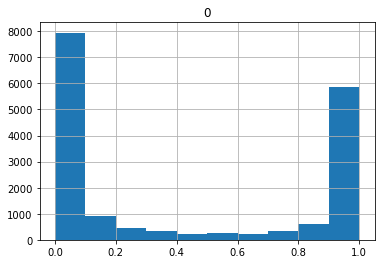

In [68]:
all = [float(r) for d,r in preds]
pd.DataFrame(all).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

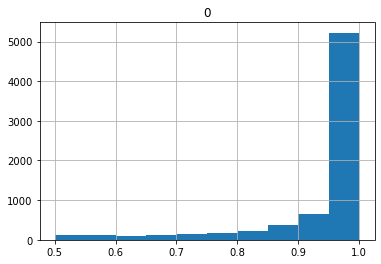

In [69]:
rs = [float(r) for d,r in preds if r>.5]
pd.DataFrame(rs).hist()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

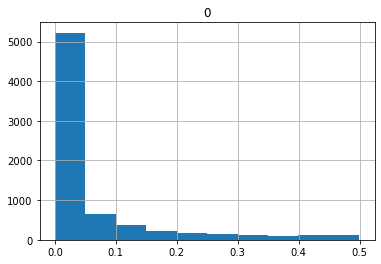

In [71]:
ds = [float(d) for d,r in preds if d<.5]
pd.DataFrame(ds).hist()

In [72]:
sum(preds.argmax(axis=1).numpy() == actual.numpy())/len(preds)

0.9460295233094113

### Tweets from 2019 Analysis

In 2019, before the twitter api limited downloads of tweeets to the most recent 7 days, I had downloaded almost 700,000 Congressional tweets for the prior year. I used the 2019 tweets to train a new model.

In [ ]:
prior_path = Path("/home/cdaniels/fastai-projects/blue-or-red")
tweet_dir = prior_path/'data_full'

df = pd.DataFrame(columns=['handle','text']) 
for t in tweet_dir.ls():
    dft = pd.read_csv(t)
    df = pd.concat([df,dft],ignore_index=True)
df.text = df.text.str.replace('[\\r,\\n]','') # An \\r in text can split a row

Clean up `text`

In [ ]:
df = cleanup_text(df)

In [ ]:
df[['text','party']].to_csv("blue_red_training_valid_2019.csv", index=False)

Double check that csv file wasn't corrupted

In [75]:
#df2 = pd.read_csv("blue_red_training_valid_2019.csv")
#len(df), len(df2),sum(df.text == df2.text), sum(df.party == df2.party),sum((df.party == 'Democrat') == (df2.party == 'Democrat'))

In [ ]:
dls = TextDataLoaders.from_csv(path, csv_fname="blue_red_training_valid_2019.csv",text_col='text', label_col="party")

In [ ]:
dls.show_batch()

In [ ]:
learner = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, .02)

In [ ]:
learner.export("blue-or-red-2019.pkl")

In [ ]:
learner = load_learner("blue-or-red-2019.pkl")

In [ ]:
learner.predict(df.text[0])

Double Check that the model predictions make sense

In [ ]:
preds, actual = learner.get_preds(0)

In [ ]:
sum(preds.argmax(axis=1).numpy() == actual.numpy())/len(preds)

### Predict 2022 Congressional Tweets using 2019 Trained Model

In [ ]:
learner = load_learner("blue-or-red-2019.pkl")

In [ ]:
#learner = load_learner("blue-or-red-2022.pkl") 

In [ ]:
df = pd.read_csv("blue_red_training_valid.csv")

In [ ]:
sum(df.party=='Democrat')/len(df)

Create a test dataloader containing the two weeks of 2022 Congressional tweets

In [ ]:
dl_test = TextDataLoaders.from_df(df, valid_pct = 0, text_col='text', shuffle=False)[0] 

Get predictions of 2022 tweets on model trained with 2019 tweets

In [ ]:
predicts, actuals = learner.get_preds(dl=dl_test)

In [ ]:
sum(predicts.argmax(axis=1).numpy() == actuals.numpy())/len(predicts)

#### The 2019 model did not predict 2022 Democratic or Republican Congressperson tweets very well. The accuracy was only 48%.

## Documentation on using a Test DataLoaders and learner.get_preds()

### How to Create a Test Data Set:
- It's probably easiest to create a DataLoader NOT a Dataset
- It is NOT necessary to indicate which are `x,y` elements, i.e, no need to indicate the lable. This will be provided by the learner
- Set `valid_pct = 0` to avoid splitting the data into train and valid dataloaders
- `dls = DataLoaders.from_` factory methods create two dataloaders, i.e., train and valid
- `dls[0]` is the train DataLoader and `dls[1]` is the valid DataLoader
- When using the `DataLoader.from_` factory methods to create a test dataLoader, select a single dataloader, i.e., `dl_test = dls[0]`
- `dl_test` is comprised of a single dataLoader containing multiple randomly orderd batches of paired, `x,y`

### Using `get_preds` method
- The learner can be the created directly through training or else loaded by `load_learner("some-export.pkl")`
- `learner.get_preds(dl = dl_test)`returns two Tensor arrays -> `predicts`, `actuals`
- `predicts` is a TensorText array, itself comprised of TensorText arrays, where each array contains the predicted probabilities of each catagory
- `actuals` is a TensorText array, where each element is the actual catagory
- In other words, `predicts` relates to the prediction of the model whereas, `actuals` is the original lable for that catatory
- `predicts` and `actuals` are all that is needed to determine the accuracy of the predictions

In [ ]:
# Sample Code
df_2022 = pd.read_csv("blue_red_training_valid.csv")
learner = load_learner("blue-or-red-2022.pkl")
dl_test = TextDataLoaders.from_df(df_2022, text_col='text', valid_pct=0)[0] # Important to choose first dataLoader
predicts, actuals = learner.get_preds(dl = dl_test)
sum(predicts.argmax(axis=1).numpy() == actuals.numpy())/len(predicts)